# Adversarial Search: Playing Connect 4

Student Name: Jonathan

I have used the following AI tools: ChatGPT and Google Gemini

I understand that my submission needs to be my own work: JM

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

Initial State: Empty 6 by 7 board

Actions: Play the bottom most empty slot in a column

Transition Model: the bottom most empty slot in a column is given a -1 or 1 for player1 or player2

Goal State: Terminal: Did a player win or is the game a draw. Utility: If player1 wins +1 or player2 wins -1 or 0 for draw


How big is the state space? Give an estimate and explain it.

Given the dimensions of a normal connect 4 board with 7 columns and 6 rows we consider the following total space 6x7 = 42 and then given there are 3 scenarios of each space being -1,1 or 0 we can conclude the state space being about 3 ^ 42 or about 109,418,989,131,512,359,209 as a state space.

How big is the game tree that minimax search will go through? Give an estimate and explain it.





The game tree that minimax search will go through would be about 42! given the various amount of subtrees created for each instance a move could possibly be made.


## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [36]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

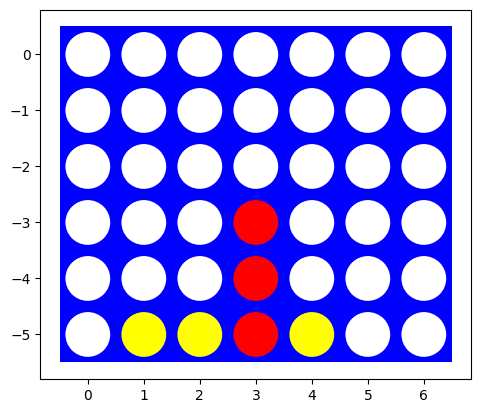

In [37]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [94]:
def actions(state):
  rows, cols = np.where(np.array(state)==0)
  available_spaces = [(int(row), int(col)) for row, col in zip(rows, cols)]
  available_moves = []

  moves = {}
  for i in range(len(state[0])):
    moves[i] = 0
  for i in range (len(available_spaces)):
    if available_spaces[i][0] == 0 and moves[available_spaces[i][1]] == 0:
      continue
    moves[available_spaces[i][1]] = max(available_spaces[i][0], moves[available_spaces[i][1]])
  return moves

def result(state, player, action):
  if state[action[0]][action[1]] != 0:
    raise ValueError("Invalid action")
  state = state.copy()
  state[action[0]][action[1]] = player
  return state

def utility(state, player = -1):
  goal = check_board(state)
  if goal == 'd':
    return 0
  if goal == player:
    return 1
  if goal == other(player):
    return -1
  return None

def terminal(state):
    return check_board(state)!='n'

def check_board(state):
    state = np.array(state).reshape((len(state), len(state.T)))

    def check_four(line):
        for i in range(len(line) - 3):
            if line[i] != 0 and line[i] == line[i+1] == line[i+2] == line[i+3]:
                return line[i]
        return None
    for row in state:
        winner = check_four(row)
        if winner:
            return winner
    for col in state.T:
        winner = check_four(col)
        if winner:
            return winner
    for i in range(-2, 4):
        diag = np.diagonal(state, offset=i)
        winner = check_four(diag)
        if winner:
            return winner
    flipped = np.fliplr(state)
    for i in range(-2, 4):
        diag = np.diagonal(flipped, offset=i)
        winner = check_four(diag)
        if winner:
            return winner
    if np.all(state != 0):
        return 'd'
    return 'n'

def other(player):
    if player == -1: return 1
    else: return -1


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [41]:
import random
def random_player(board, player = None):
  key = random.choice(list(actions(board)))
  while board[actions(board)[key]][key] != 0:
    key = random.choice(list(actions(board)))
  return (actions(board)[key],key)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [100]:
def play(player1=1,player2=-1,N=100,show_final_board = False):
  results = {-1:0,1:0,'d':0}
  for i in range(N):
    board = empty_board()
    while True:
      a = random_player(board,-1)
      board = result(board,-1,a)
      win = check_board(board)
      if win!='n':
        results[win]+=1
        break
      b = random_player(board,1)
      board = result(board,1,b)
      win = check_board(board)
      if win!='n':
        results[win]+=1
        break
    if show_final_board:
     visualize(board)
  return results

print(play())

{-1: 49, 1: 48, 'd': 3}


Given 100 runs the wins for player 1 and 2 are random but near even with very little draws. This can happen out of just pure randomness.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [23]:

import numpy as np

class Game:
    def __init__(self):
        pass

    def actions(self, state):
        rows, cols = np.where(np.array(state) == 0)
        available_spaces = [(int(row), int(col)) for row, col in zip(rows, cols)]
        available_moves = []

        moves = {}
        for i in range(len(state[0])):
            moves[i] = 0
        for i in range(len(available_spaces)):
            if available_spaces[i][0] == 0 and moves[available_spaces[i][1]] == 0:
                continue
            moves[available_spaces[i][1]] = max(available_spaces[i][0], moves[available_spaces[i][1]])
        available_moves = [(row, col) for col, row in moves.items() if row != 0 or (row == 0 and np.array(state)[row, col] == 0)]
        return available_moves

    def result(self, state, player, action):
        if state[action[0]][action[1]] != 0:
            raise ValueError("Invalid action")
        new_state = np.copy(state)
        new_state[action[0]][action[1]] = player
        return new_state

    def utility(self, state, player=-1):
        goal = check_board(state)
        if goal == 'd':
            return 0
        if goal == player:
            return 1
        if goal == other(player):
            return -1
        return None

    def is_terminal(self, state):
        return check_board(state) != 'n'

    def to_move(self, state):
        flat = np.array(state).flatten()
        x_count = np.sum(flat == -1)
        o_count = np.sum(flat == 1)
        return -1 if x_count <= o_count else 1

def check_board(state):
    state = np.array(state).reshape((len(state), len(state.T)))

    def check_four(line):
        for i in range(len(line) - 3):
            if line[i] != 0 and line[i] == line[i+1] == line[i+2] == line[i+3]:
                return line[i]
        return None
    for row in state:
        winner = check_four(row)
        if winner:
            return winner
    for col in state.T:
        winner = check_four(col)
        if winner:
            return winner
    for i in range(-2, 4):
        diag = np.diagonal(state, offset=i)
        winner = check_four(diag)
        if winner:
            return winner
    flipped = np.fliplr(state)
    for i in range(-2, 4):
        diag = np.diagonal(flipped, offset=i)
        winner = check_four(diag)
        if winner:
            return winner
    if np.all(state != 0):
        return 'd'

    return 'n'

def other(player):
    return 1 if player == -1 else -1

def alpha_beta_search(game, state):
    player = game.to_move(state)
    value, move = max_value(game, state, -np.inf, np.inf, player)
    return move

def max_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = -np.inf
    move = None
    for a in game.actions(state):
        v2, _ = min_value(game, game.result(state, player, a), alpha, beta, player)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def min_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = np.inf
    move = None
    for a in game.actions(state):
        v2, _ = max_value(game, game.result(state, other(player), a), alpha, beta, player)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            return v, move
    return v, move


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Board 1:


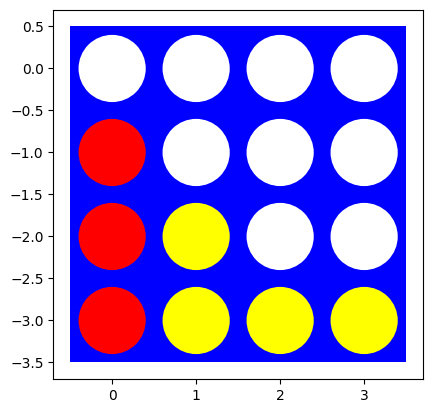

Agent selected move: (0, 0)

Time taken for agent to select next move: 0.0181 seconds


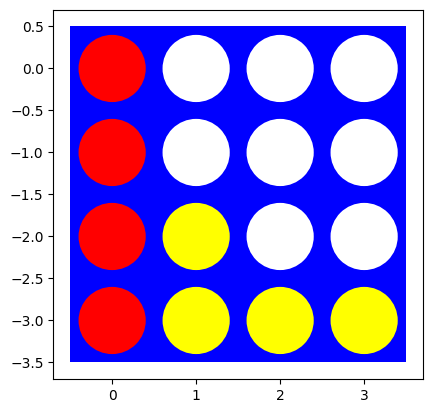

Board 2:


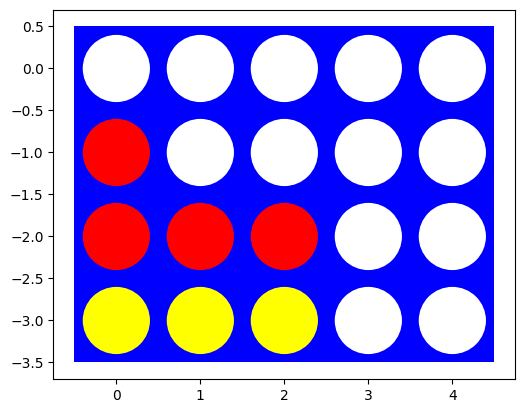

Agent selected move: (3, 3)

Time taken for agent to select next move: 0.4720 seconds


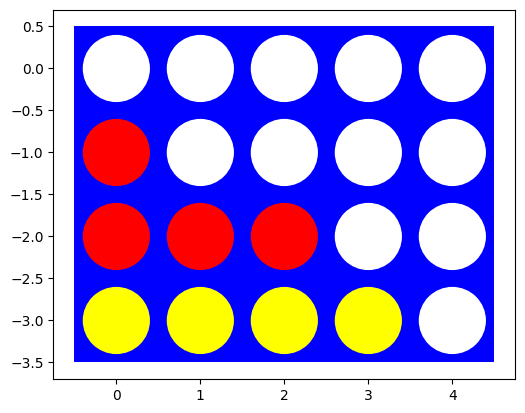

Board 3:


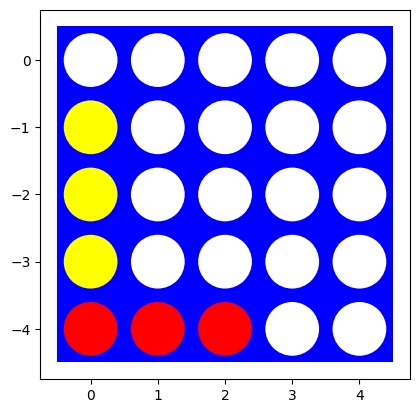

Agent selected move: (0, 0)

Time taken for agent to select next move: 0.7027 seconds


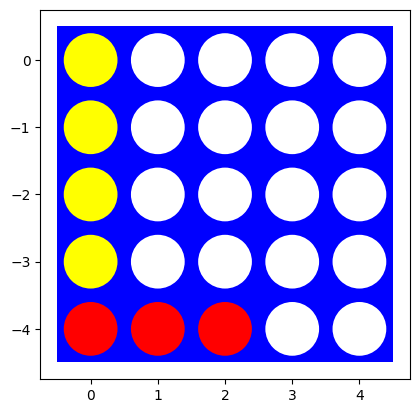

Board 4:


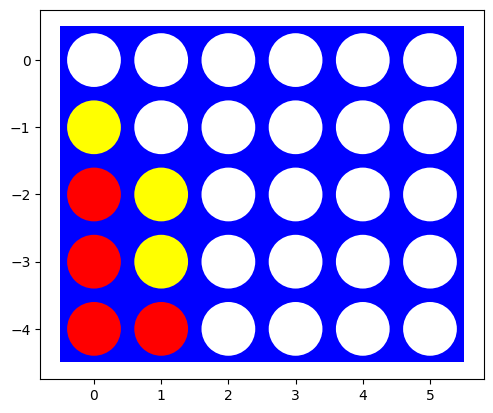

Agent selected move: (0, 0)

Time taken for agent to select next move: 237.2471 seconds


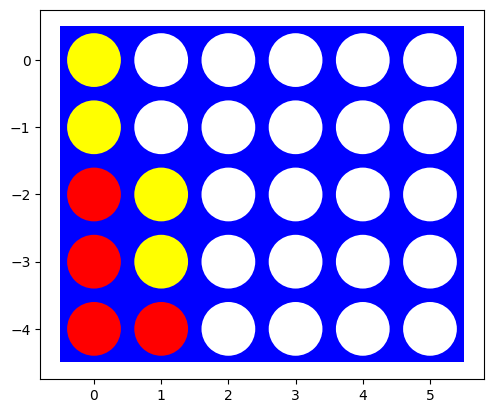

Board 5:


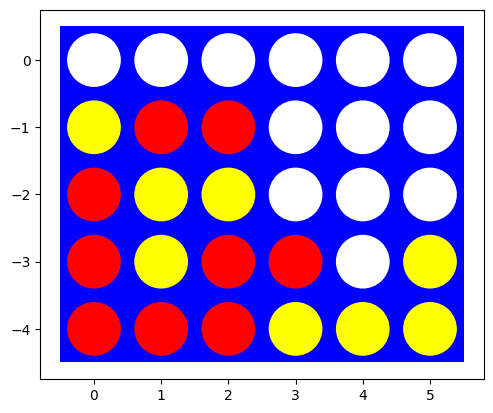

Agent selected move: (2, 3)

Time taken for agent to select next move: 2.2742 seconds


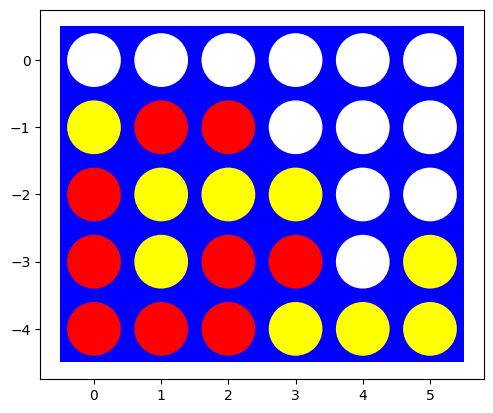

In [8]:

import time
import numpy as np

game = Game()

boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [1, -1, 0, 0],
    [1, -1, -1, -1]
])

board2 = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [-1, -1, -1, 0, 0]
])

board3 = np.array([
    [0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0]
])

board4 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0]
])

board5 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0],
    [1, -1, -1, 0, 0, 0],
    [1, -1, 1, 1, 0, -1],
    [1, 1, 1, -1, -1, -1]
])

boards = [board1, board2, board3, board4, board5]

for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    player = game.to_move(board)
    if move is not None:
      board = result(board,player,move)
      visualize(board)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

Depending on the size of the board and the number of spaces available the time seems to increase exponential for more spaces and size creating an issue for a 6x7 board making this not feasible. In the above examples this is demonstrated with the associated times.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [9]:
# A simple move ordering strategy that can be used is by taking the center
# most slot and sorting around this as via online the best strategies
# for connect4 rely on taking advantage of the center.

def alpha_beta_search(game, state):
    player = game.to_move(state)
    value, move = max_value(game, state, -np.inf, np.inf, player)
    return move

def order_moves(state, moves):
    center = len(state[0]) // 2
    return sorted(moves, key=lambda move: abs(move[1] - center))

def max_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = -np.inf
    move = None
    for a in order_moves(state, game.actions(state)):
        v2, _ = min_value(game, game.result(state, player, a), alpha, beta, player)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def min_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = np.inf
    move = None
    for a in order_moves(state, game.actions(state)):
        v2, _ = max_value(game, game.result(state, other(player), a), alpha, beta, player)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            return v, move
    return v, move


Board 1:


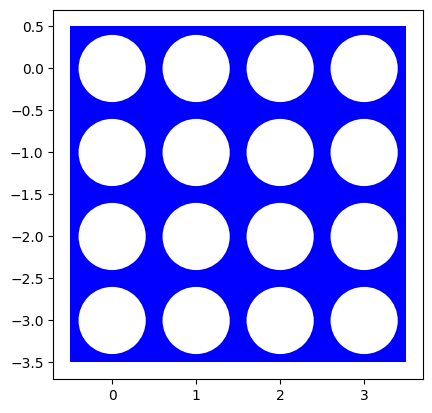

Agent selected move: (3, 2)

Time taken for agent to select next move: 11.2489 seconds


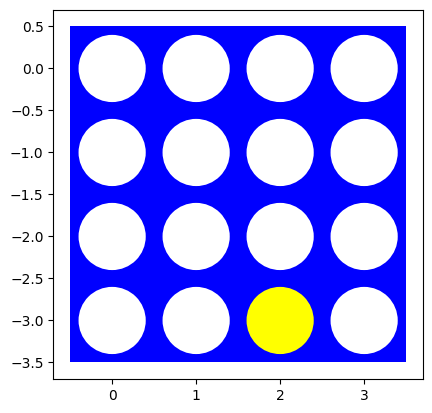

In [10]:
game = Game()

# Test Boards
boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

boards = [board1]
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    player = game.to_move(board)
    if move is not None:
      board = result(board,player,move)
      visualize(board)

boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

boards = [board1]
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    player = game.to_move(board)
    if move is not None:
      board = result(board,player,move)
      visualize(board)

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [60]:
# Your code/ answer goes here.

def empty_board(shape=(4, 4)):
    return np.full(shape=shape, fill_value=0)

def play(player1=1,player2=-1,N=20,show_final_board = False):
  results = {-1:0,1:0,'d':0}
  for i in range(N):
    board = empty_board()
    while True:
      a = random_player(board,-1)
      board = result(board,-1,a)
      win = check_board(board)
      if win!='n':
        results[win]+=1
        break
      b = 1
      move = alpha_beta_search(game,board)
      board = result(board,b,move)
      win = check_board(board)
      if win!='n':
        results[win]+=1
        break

  return results

print(play())

{-1: 0, 1: 19, 'd': 1}


## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [91]:
def heuristic(state, player):
    state = np.array(state)
    opponent = 1 if player == -1 else -1
    score = 0

    for line in get_all_lines(state):
        score += count_consecutive(line, player)
        score -= count_consecutive(line, opponent)  # Defensive play

    return score

def get_all_lines(state):
    lines = []

    # Rows
    for row in state:
        lines.append(row)

    # Columns
    for col in state.T:
        lines.append(col)

    # Diagonals TL-BR
    for i in range(-state.shape[0]+1, state.shape[1]):
        lines.append(np.diagonal(state, offset=i))

    # Diagonals TR-BL
    flipped = np.fliplr(state)
    for i in range(-flipped.shape[0]+1, flipped.shape[1]):
        lines.append(np.diagonal(flipped, offset=i))

    return lines

def count_consecutive_advanced(line, player):
    score = 0
    line = list(line)
    for i in range(len(line) - 3):
        window = line[i:i+4]
        player_count = window.count(player)
        empty_count = window.count(0)
        opp_count = window.count(-player)

        if opp_count == 0:  # Only consider if opponent not blocking
            if player_count == 4:
                score += 1000
            elif player_count == 3 and empty_count == 1:
                score += 50
            elif player_count == 2 and empty_count == 2:
                score += 10
            elif player_count == 1 and empty_count == 3:
                score += 1
    return score


### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

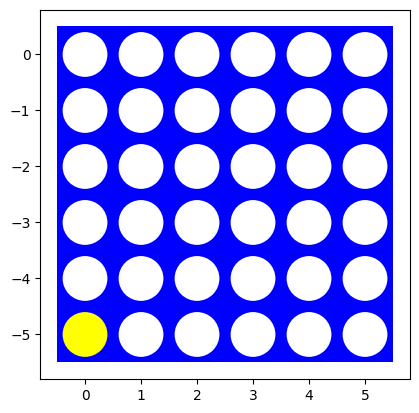

In [92]:
def alpha_beta_search(game, state, max_depth):
    player = game.to_move(state)
    value, move = max_value(game, state, -np.inf, np.inf, player, 0, max_depth)
    return move

def max_value(game, state, alpha, beta, player, depth, max_depth):
    if game.is_terminal(state):
        return game.utility(state, player), None
    if depth >= max_depth:
        return heuristic(state, player), None

    v = -np.inf
    move = None
    for a in game.actions(state):
        v2, _ = min_value(game, game.result(state, player, a), alpha, beta, player, depth + 1, max_depth)
        if v2 > v:
            v, move = v2, a
        alpha = max(alpha, v)
        if v >= beta:
            break
    return v, move

def min_value(game, state, alpha, beta, player, depth, max_depth):
    if game.is_terminal(state):
        return game.utility(state, player), None
    if depth >= max_depth:
        return heuristic(state, player), None

    v = np.inf
    move = None
    for a in game.actions(state):
        v2, _ = max_value(game, game.result(state, other(player), a), alpha, beta, player, depth + 1, max_depth)
        if v2 < v:
            v, move = v2, a
        beta = min(beta, v)
        if v <= alpha:
            break
    return v, move


board = empty_board()
game = Game()

move = alpha_beta_search(game, board, 4)
board = result(board,-1,move)
visualize(board)



Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

Board 1:


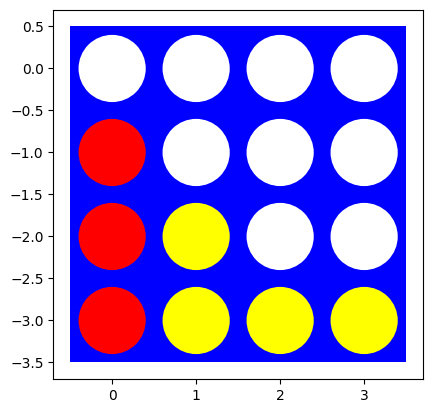

Agent selected move: (0, 0)

Time taken for agent to select next move: 0.0127 seconds


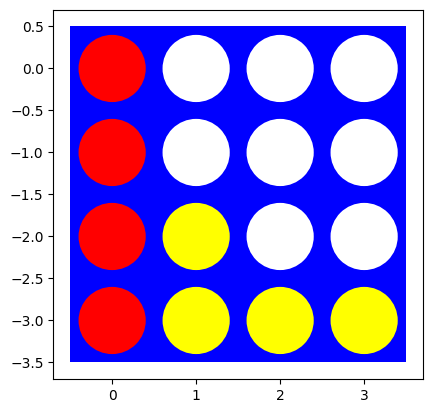

Board 2:


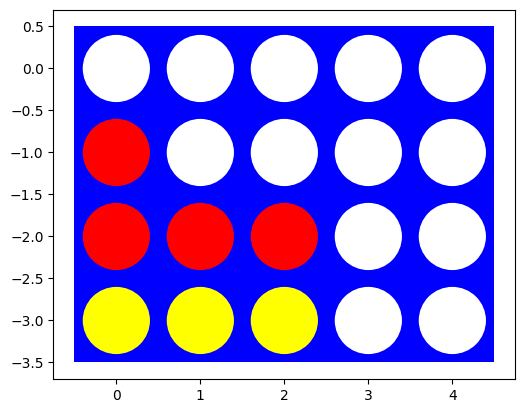

Agent selected move: (3, 3)

Time taken for agent to select next move: 0.5435 seconds


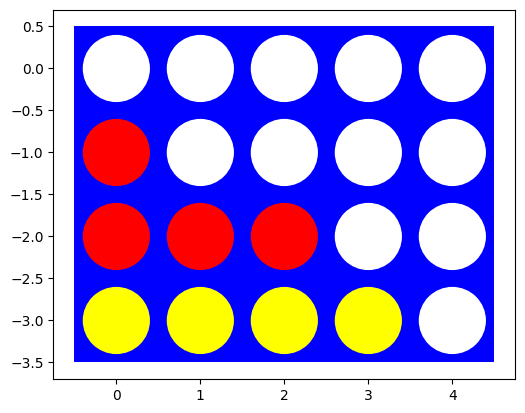

Board 3:


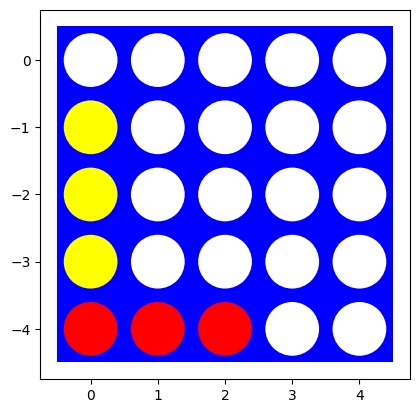

Agent selected move: (0, 0)

Time taken for agent to select next move: 0.7436 seconds


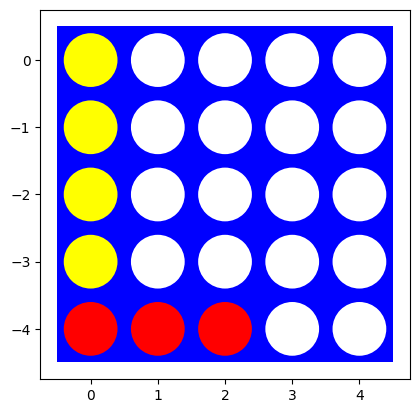

Board 4:


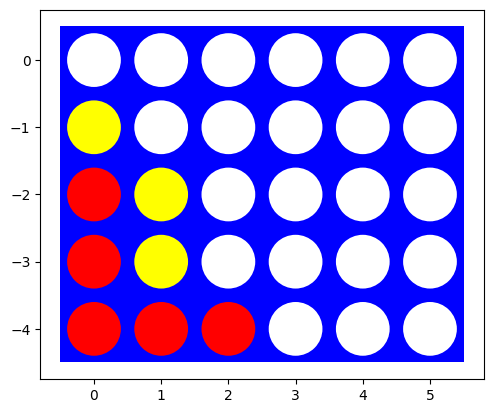

Agent selected move: (4, 3)

Time taken for agent to select next move: 1.8708 seconds


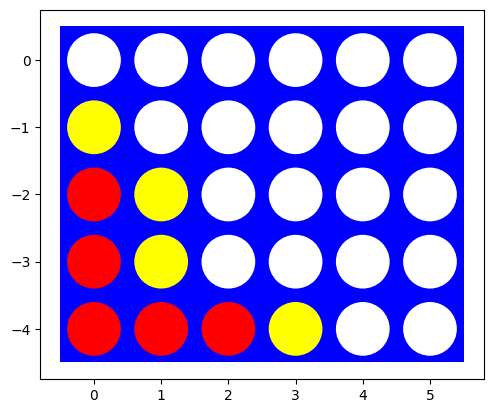

Board 5:


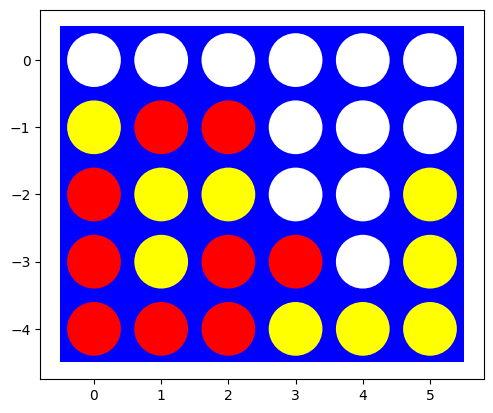

Agent selected move: (3, 4)

Time taken for agent to select next move: 3.9653 seconds


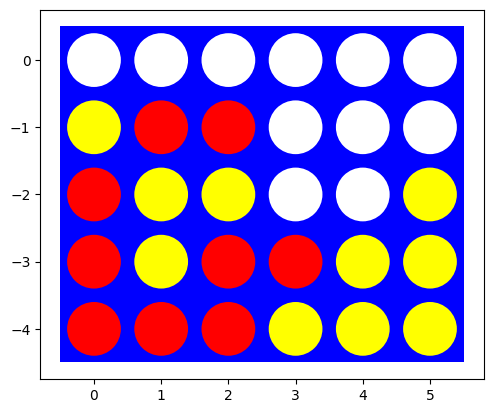

In [93]:
# Your code/ answer goes here.
# Your code/ answer goes here.
import time
import numpy as np

# Initialize game
game = Game()

# Test Boards
boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [1, -1, 0, 0],
    [1, -1, -1, -1]
])

board2 = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [-1, -1, -1, 0, 0]
])

board3 = np.array([
    [0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0]
])

board4 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0]
])

board5 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0],
    [1, -1, -1, 0, 0, -1],
    [1, -1, 1, 1, 0, -1],
    [1, 1, 1, -1, -1, -1]
])

boards = [board1, board2, board3, board4, board5]

# Test Loop
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board,10)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    player = game.to_move(board)
    if move is not None:
      board = result(board,player,move)
      visualize(board)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

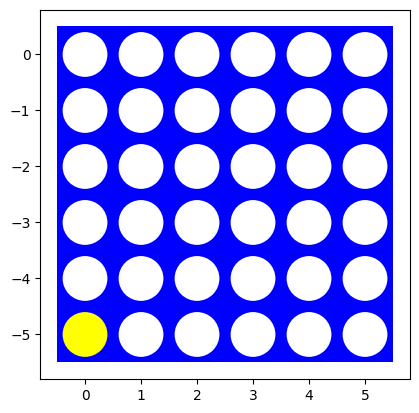

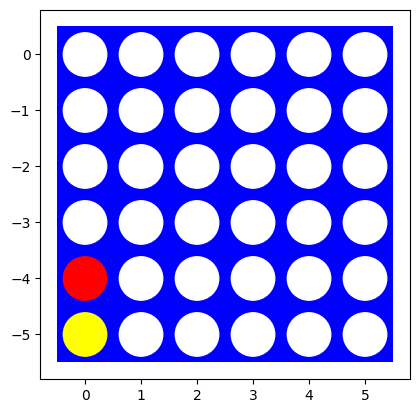

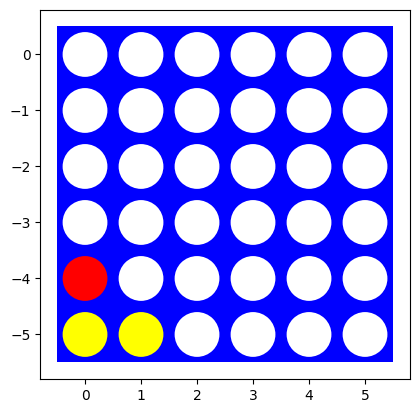

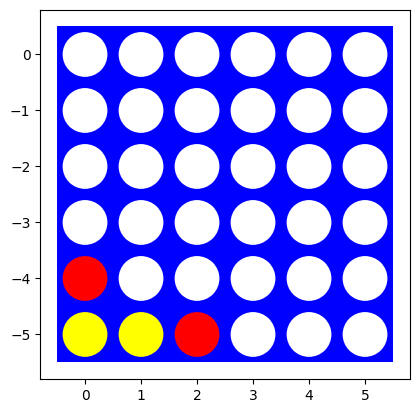

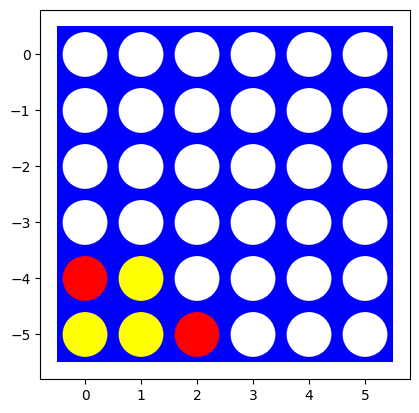

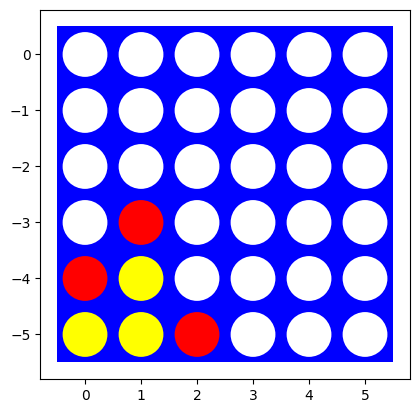

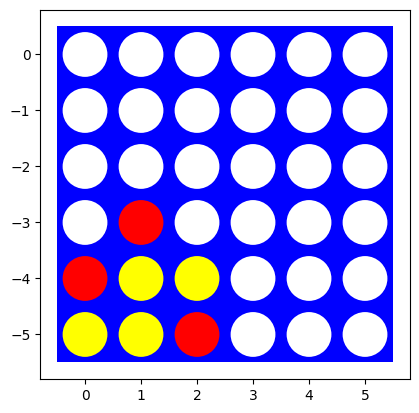

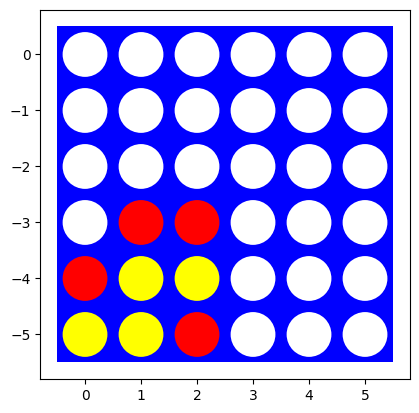

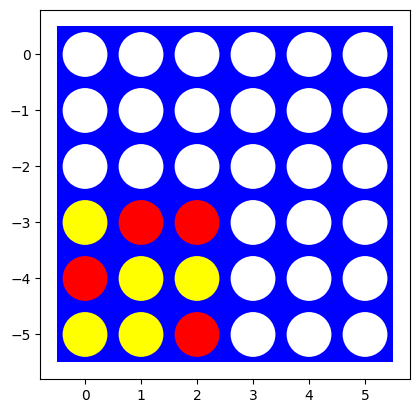

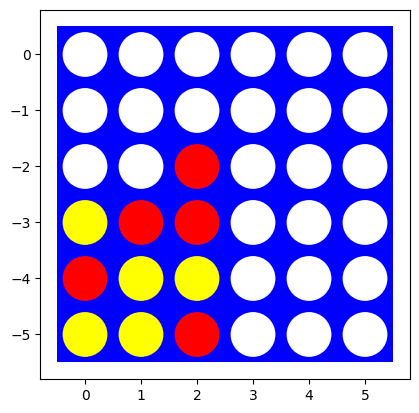

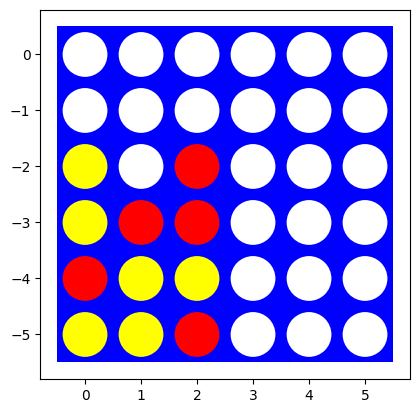

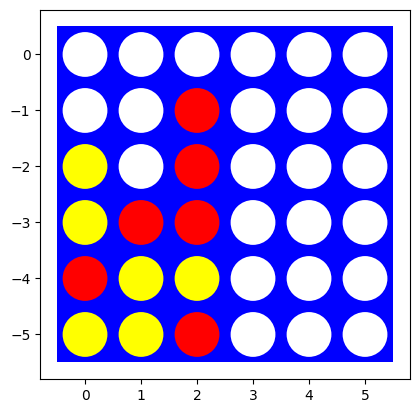

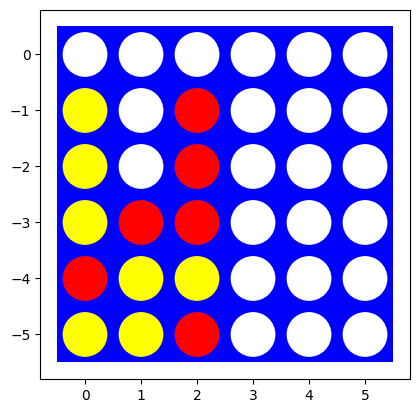

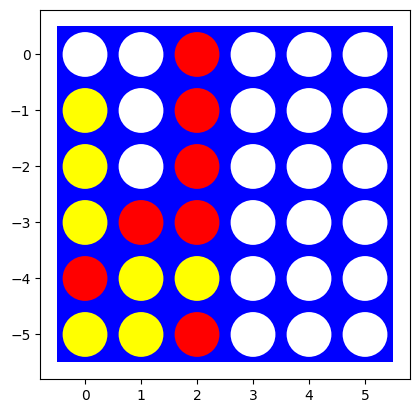

{-1: 0, 1: 1, 'd': 0}


In [98]:
# Your code/ answer goes here.
def empty_board(shape=(6, 6)):
    return np.full(shape=shape, fill_value=0)

def play(player1=1,player2=-1,N=1,show_final_board = False):
  results = {-1:0,1:0,'d':0}
  for i in range(N):
    board = empty_board()
    while True:
      a = -1
      move = alpha_beta_search(game,board,6)
      board = result(board,a,move)
      win = check_board(board)
      visualize(board)
      if win!='n':
        results[win]+=1
        break
      b = 1
      move = alpha_beta_search(game,board,2)
      board = result(board,b,move)
      win = check_board(board)
      visualize(board)
      if win!='n':
        results[win]+=1
        break

  return results

print(play())
